**Course:** Neural Computing and Deep Learning
---
**Title:** Project 6
---
**Mahdi Mirfendereski - 401131065**
---


# Libraries

In [2]:
# ! python.exe -m pip install --upgrade pip
! pip3 install nltk
! pip install --upgrade nltk


In [1]:
import numpy as np
import math
import json
import os
import pandas
import string
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import random
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pylab import bone, pcolor, colorbar, plot, show
from keras.layers import Dense, SimpleRNN
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import load_model
from keras.models import Sequential
from tensorflow.keras import utils
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, GRU
import re

AUTOTUNE = tf.data.AUTOTUNE
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

KeyboardInterrupt: 

# 1

In [ ]:

def load_dataset():
   train_comments = []
   train_labels = []
   test_comments = []
   test_labels = []

   train_neg = '../Inputs/aclImdb/train/neg'
   train_pos = '../Inputs/aclImdb/train/pos'
   test_neg = '../Inputs/aclImdb/test/neg'
   test_pos = '../Inputs/aclImdb/test/pos'
   
   print('loading...')
   for filename in os.listdir(train_neg):
      with open(os.path.join(train_neg, filename), 'r', encoding="utf8") as f:
         train_comments.append([f.read(), 0])
   print('loaded train_neg')

   for filename in os.listdir(train_pos):
      with open(os.path.join(train_pos, filename), 'r', encoding="utf8") as f:
         train_comments.append([f.read(), 1])
   print('loaded train_pos')

   for filename in os.listdir(test_neg):
      with open(os.path.join(test_neg, filename), 'r', encoding="utf8") as f:
         test_comments.append([f.read(), 0])
   print('loaded test_neg')

   for filename in os.listdir(test_pos):
      with open(os.path.join(test_pos, filename), 'r', encoding="utf8") as f:
         test_comments.append([f.read(), 1])
   print('loaded test_pos')
   
   train_df = pd.DataFrame(train_comments, columns=['comment', 'label'])
   test_df = pd.DataFrame(test_comments, columns=['comment', 'label'])

   return train_df, test_df


train_df, test_df = load_dataset()

loading...
loaded train_neg
loaded train_pos
loaded test_neg
loaded test_pos


In [ ]:
train_df

,comment,label
0,Story of a man who has unnatural feelings for ...,0
1,Airport '77 starts as a brand new luxury 747 p...,0
2,This film lacked something I couldn't put my f...,0
3,"Sorry everyone,,, I know this is supposed to b...",0
4,When I was little my parents took me along to ...,0
...,...,...
24995,"Seeing as the vote average was pretty low, and...",1
24996,"The plot had some wretched, unbelievable twist...",1
24997,I am amazed at how this movie(and most others ...,1
24998,A Christmas Together actually came before my t...,1


In [ ]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def remove_whitespace(text):
    return  " ".join(text.split()) 

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

def cleanhtml(text):
    CLEANR = re.compile('<.*?>') 
    cleantext = re.sub(CLEANR, '', text)
    return cleantext    
    
def remove_urls(text):
    return re.sub(r"http\S+", "", text)

In [ ]:
train_df['comment'] = train_df['comment'].apply(lambda x: remove_punctuation(x))
train_df['comment'] = train_df['comment'].apply(lambda x: x.lower())
train_df['comment'] = train_df['comment'].apply(lambda x: remove_whitespace(x))
train_df['comment'] = train_df['comment'].apply(lambda x: cleanhtml(x))
train_df['comment'] = train_df['comment'].apply(lambda x: remove_urls(x))
train_df['comment'] = train_df['comment'].apply(lambda x: remove_stopwords(x))
# train_df['comment'] = train_df['comment'].apply(lambda x: word_tokenize(x))

train_df

,comment,label
0,"[story, man, unnatural, feelings, pig, starts,...",0
1,"[airport, 77, starts, brand, new, luxury, 747,...",0
2,"[film, lacked, something, couldnt, put, finger...",0
3,"[sorry, everyone, know, supposed, art, film, w...",0
4,"[little, parents, took, along, theater, see, i...",0
...,...,...
24995,"[seeing, vote, average, pretty, low, fact, cle...",1
24996,"[plot, wretched, unbelievable, twists, however...",1
24997,"[amazed, movieand, others, average, 5, stars, ...",1
24998,"[christmas, together, actually, came, time, iv...",1


In [ ]:
test_df['comment'] = test_df['comment'].apply(lambda x: remove_punctuation(x))
test_df['comment'] = test_df['comment'].apply(lambda x: x.lower())
test_df['comment'] = test_df['comment'].apply(lambda x: remove_whitespace(x))
test_df['comment'] = test_df['comment'].apply(lambda x: cleanhtml(x))
test_df['comment'] = test_df['comment'].apply(lambda x: remove_urls(x))
test_df['comment'] = test_df['comment'].apply(lambda x: remove_stopwords(x))
test_df

,comment,label
0,"[mr, costner, dragged, movie, far, longer, nec...",0
1,"[example, majority, action, films, generic, bo...",0
2,"[first, hate, moronic, rappers, couldnt, act, ...",0
3,"[even, beatles, could, write, songs, everyone,...",0
4,"[brass, pictures, movies, fitting, word, reall...",0
...,...,...
24995,"[extraordinarily, impressed, film, one, best, ...",1
24996,"[although, im, golf, fan, attended, sneak, pre...",1
24997,"[start, edge, love, viewer, transported, strik...",1
24998,"[movie, complexity, subtlety, makes, one, thou...",1


# 2

In [ ]:
! pip3 install gensim

In [ ]:
## load vocab from unsup

# def load_vocab():
#    train_unsup_comments = []
#    train_unsup = '../Inputs/aclImdb/train/unsup'
#    print('loading...')
#    for filename in os.listdir(train_unsup):
#       with open(os.path.join(train_unsup, filename), 'r', encoding="utf8") as f:
#          train_unsup_comments.append([f.read()])
#    print('loaded unsup')

#    unsup_df = pd.DataFrame(train_unsup_comments, columns=['comment'])

#    return unsup_df
# unsup_df = load_vocab()
# unsup_df

loading...
loaded unsup


,comment
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."
...,...
49995,"Delightfully awful! Made by David Giancola, a ..."
49996,"Watching Time Chasers, it obvious that it was ..."
49997,At the beginning we can see members of Troma t...
49998,"The movie was incredible, ever since I saw it ..."


In [ ]:
# unsup_df['comment'] = unsup_df['comment'].apply(lambda x: remove_punctuation(x))
# # unsup_df['comment'] = unsup_df['comment'].apply(lambda x: x.lower())
# # unsup_df['comment'] = unsup_df['comment'].apply(lambda x: remove_whitespace(x))
# # unsup_df['comment'] = unsup_df['comment'].apply(lambda x: cleanhtml(x))
# # unsup_df['comment'] = unsup_df['comment'].apply(lambda x: remove_urls(x))
# # unsup_df['comment'] = unsup_df['comment'].apply(lambda x: remove_stopwords(x))
# unsup_df

,comment,clean_comment
0,"I admit, the great majority of films released ...","[admit, great, majority, films, released, say,..."
1,"Take a low budget, inexperienced actors doubli...","[take, low, budget, inexperienced, actors, dou..."
2,"Everybody has seen 'Back To The Future,' right...","[everybody, seen, back, future, right, whether..."
3,Doris Day was an icon of beauty in singing and...,"[doris, day, icon, beauty, singing, acting, wa..."
4,"After a series of silly, fun-loving movies, 19...","[series, silly, funloving, movies, 1955, big, ..."
...,...,...
49995,"Delightfully awful! Made by David Giancola, a ...","[delightfully, awful, made, david, giancola, g..."
49996,"Watching Time Chasers, it obvious that it was ...","[watching, time, chasers, obvious, made, bunch..."
49997,At the beginning we can see members of Troma t...,"[beginning, see, members, troma, team, company..."
49998,"The movie was incredible, ever since I saw it ...","[movie, incredible, ever, since, saw, 1977, to..."


In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_test = pd.concat([train_df, test_df], axis=0).sample(frac=1).reset_index(drop=True)
train_test

,comment,label
0,"[remember, seeing, salem, movie, theater, used...",1
1,"[stephen, king, tv, movies, go, 5, 6, parts, o...",0
2,"[occasionally, one, served, new, entrée, forei...",0
3,"[independent, film, would, make, hollywood, pr...",0
4,"[probably, best, documentary, seen, long, time...",1
...,...,...
49995,"[17th, century, japan, lived, samurai, would, ...",0
49996,"[film, good, example, media, manipulation, sel...",0
49997,"[chris, noth, plays, maniac, wrote, childrens,...",1
49998,"[following, success, awful, gilligans, island,...",0


In [ ]:
from gensim.models import Word2Vec
import multiprocessing

cores = multiprocessing.cpu_count()
W2V_SIZE = 4
W2V_WINDOW = 5
W2V_MIN_COUNT = 1
VEC_SIZE = 100
# w2v_model = Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)
w2v_model = Word2Vec(window=W2V_WINDOW, vector_size=VEC_SIZE, min_count=W2V_MIN_COUNT, workers=8)
w2v_model.build_vocab(train_test['comment'], progress_per=10000)
w2v_model.train(train_test['comment'], total_examples=w2v_model.corpus_count, epochs=15, report_delay=1)

(87932485, 92117415)

# 3

In [ ]:
max_wind = sorted(list(train_test['comment'].apply(lambda x: len(x))), reverse=True)[int(0.1*len(train_test))]
max_wind

242

In [ ]:
def create_w2v_df(df):
    w2v_df = []
    for ind in df.index:
        sen_vec = []
        diff = max_wind - len(df['comment'][ind])
        counter = 0
        for i in range (max_wind):
            if i < len(df['comment'][ind]):
                sen_vec.append(w2v_model.wv.get_vector(df['comment'][ind][i]))
            else:
                sen_vec.append(np.zeros(VEC_SIZE))
        w2v_df.append(np.array(sen_vec))
    w2v_df = np.array(w2v_df)
    return w2v_df
train_w2v = create_w2v_df(train_df)    
test_w2v = create_w2v_df(test_df)    

In [ ]:
train_w2v.shape, test_w2v.shape 

((25000, 242, 100), (25000, 242, 100))

In [ ]:
np.save("train_features.npy", train_w2v)
np.save("test_features.npy", test_w2v)
np.save("train_label.npy", train_df['label'].to_numpy().reshape(-1, 1))
np.save("test_label.npy", test_df['label'].to_numpy().reshape(-1, 1))

# Load Dataset

In [2]:
### train
train_w2v = np.load("train_features.npy")
train_labels = np.load("train_label.npy")


In [2]:
### test
test_w2v = np.load("test_features.npy")
test_labels = np.load("test_label.npy")

In [3]:
max_wind = 242
W2V_SIZE = 4
W2V_WINDOW = 5
W2V_MIN_COUNT = 1
VEC_SIZE = 100

# 4

Epoch 1/10
352/352 - 18s - loss: 0.4912 - accuracy: 0.7497 - val_loss: 0.3331 - val_accuracy: 0.8600 - 18s/epoch - 51ms/step
Epoch 2/10
352/352 - 10s - loss: 0.2836 - accuracy: 0.8857 - val_loss: 0.2888 - val_accuracy: 0.8828 - 10s/epoch - 27ms/step
Epoch 3/10
352/352 - 10s - loss: 0.2450 - accuracy: 0.9022 - val_loss: 0.2834 - val_accuracy: 0.8904 - 10s/epoch - 28ms/step
Epoch 4/10
352/352 - 10s - loss: 0.2281 - accuracy: 0.9110 - val_loss: 0.2746 - val_accuracy: 0.8944 - 10s/epoch - 28ms/step
Epoch 5/10
352/352 - 10s - loss: 0.2068 - accuracy: 0.9213 - val_loss: 0.2724 - val_accuracy: 0.8924 - 10s/epoch - 28ms/step
Epoch 6/10
352/352 - 10s - loss: 0.1926 - accuracy: 0.9265 - val_loss: 0.2813 - val_accuracy: 0.8860 - 10s/epoch - 28ms/step
Epoch 7/10
352/352 - 10s - loss: 0.1784 - accuracy: 0.9320 - val_loss: 0.2853 - val_accuracy: 0.8880 - 10s/epoch - 28ms/step
Epoch 8/10
352/352 - 10s - loss: 0.1645 - accuracy: 0.9403 - val_loss: 0.2983 - val_accuracy: 0.8848 - 10s/epoch - 29ms/step


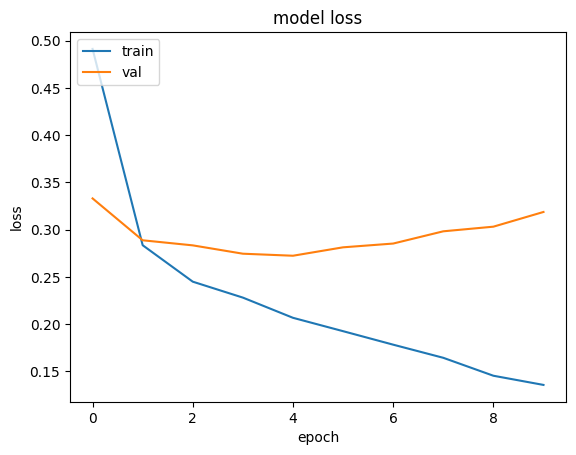

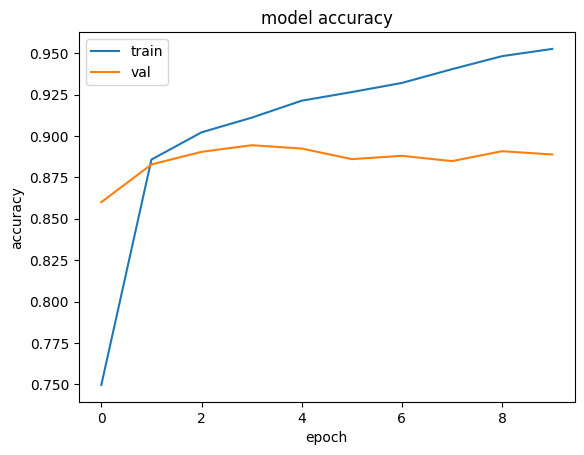

In [ ]:
rnn_arts = [
    [16, 16],
    [16],
    # [32],
    # [64],
    # [128],
    # [32, 32],
    # [64, 64],
    # [128, 128],
    # [16, 16, 16],
    # [32, 32, 32],
    # [64, 64, 64],
    # [128, 128, 128],
]

dense_arts = [
    # [32,32,32],
    # [64,32,16],
    # [32,16,16],
    # [128,64,32],
    [64,16,16],
]
result = {}
bidirection =   True
last_layer = False
for cell in [GRU, LSTM]:
    for rnn_art in rnn_arts:
        for dense_art in dense_arts:
            # train_rnn(cell, bidirection, rnn_art, dense_art)


            model = Sequential()
            model.add(keras.Input(shape=(max_wind, VEC_SIZE)))
            if bidirection:
                for units in rnn_art:
                    if len(rnn_art) == 2 and not last_layer:
                        last_layer = True
                        model.add(Bidirectional(cell(units, return_sequences=True)))
                    else:
                        model.add(Bidirectional(cell(units, return_sequences=False)))
                        
            else:
                for units in rnn_art:
                    model.add(cell(units))
            for units in dense_art:
                model.add(Dense(units, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            history = model.fit(train_w2v,  train_labels, batch_size=64, epochs=10, validation_split=0.1,verbose=2)

            nn_name = ''
            if cell == LSTM:
                nn_name = f'LSTM-{rnn_art}-{dense_art}'
            else:
                nn_name = f'GRU-{rnn_art}-{dense_art}'
            result[nn_name] = []
            model.save_weights(f"models/{nn_name}")
            model.save(f'{nn_name}.h5')
            print(nn_name, '====> train acc:', history.history['accuracy'][-1])
            result[nn_name].append(history.history['accuracy'][-1])
            # print(cell, rnn_art, dense_art, f'===> train_accuracy: {train_accu}, test_accuracy: {test_accu}')

            plt.figure()
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train','val'], loc = 'upper left')
            plt.show()
            plt.figure()
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train','val'], loc = 'upper left')
            plt.show()
            break
        break
    break



In [3]:
nns = [
    'LSTM-[16]-[64, 16, 16].h5',
    'LSTM-[16, 16]-[64, 16, 16].h5',
    'GRU-[16]-[64, 16, 16].h5',
    'GRU-[16, 16]-[64, 16, 16].h5'
]

782/782 [==============================] - 8s 7ms/step


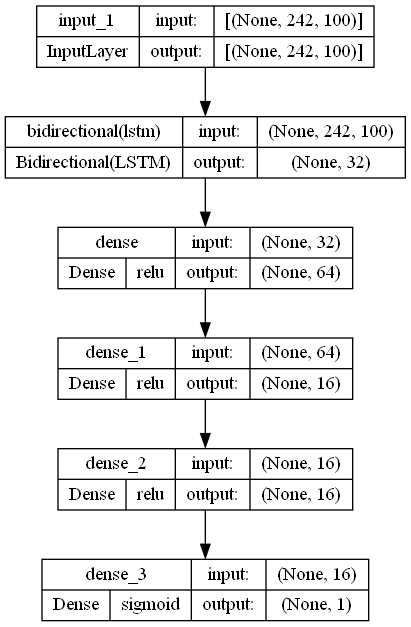

In [5]:
nn = nns[0]
model = load_model(nns[0])
preds = model.predict(test_w2v)
preds = [0 if row < 0.50 else 1 for row in preds]
cm = confusion_matrix(test_labels.reshape(1,-1)[0], preds, labels=[0, 1])
keras.utils.plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)

Test accuracy 0.8724


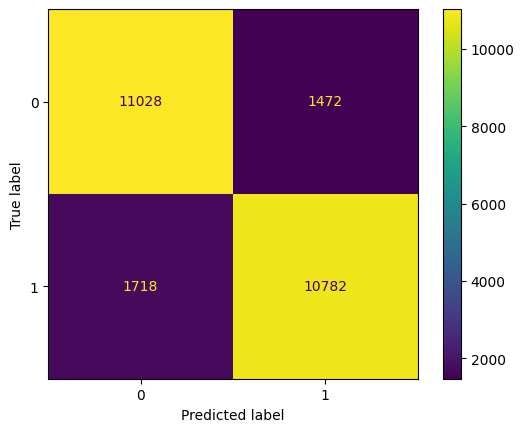

In [6]:
print(f'Test accuracy {accuracy_score(test_labels.reshape(1,-1)[0], preds)}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()  

782/782 [==============================] - 14s 13ms/step


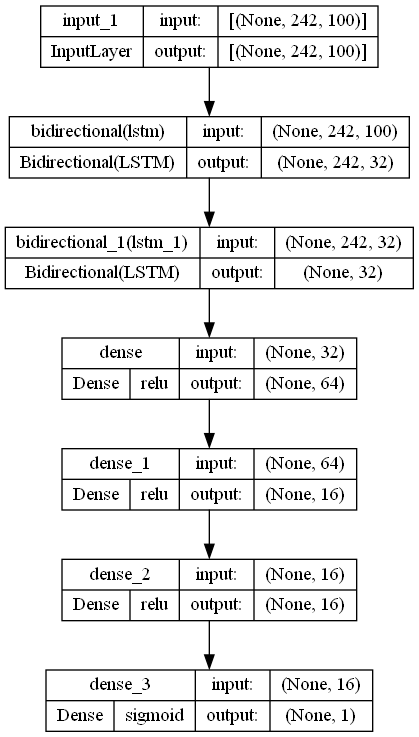

In [5]:
## 2
model = load_model(nns[1])
preds = model.predict(test_w2v)
preds = [0 if row < 0.50 else 1 for row in preds]
cm = confusion_matrix(test_labels.reshape(1,-1)[0], preds, labels=[0, 1])
keras.utils.plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)

Test accuracy 0.88652


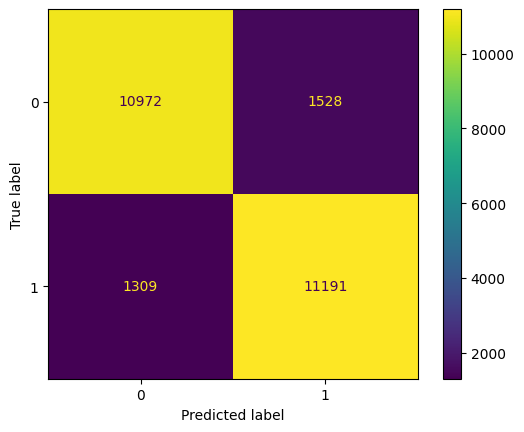

In [6]:
print(f'Test accuracy {accuracy_score(test_labels.reshape(1,-1)[0], preds)}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()  

782/782 [==============================] - 8s 7ms/step


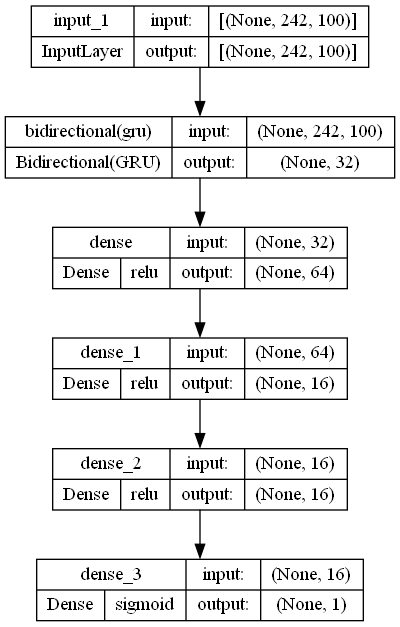

In [4]:
## 3
model = load_model(nns[2])
preds = model.predict(test_w2v)
preds = [0 if row < 0.50 else 1 for row in preds]
cm = confusion_matrix(test_labels.reshape(1,-1)[0], preds, labels=[0, 1])
keras.utils.plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)

Test accuracy 0.87932


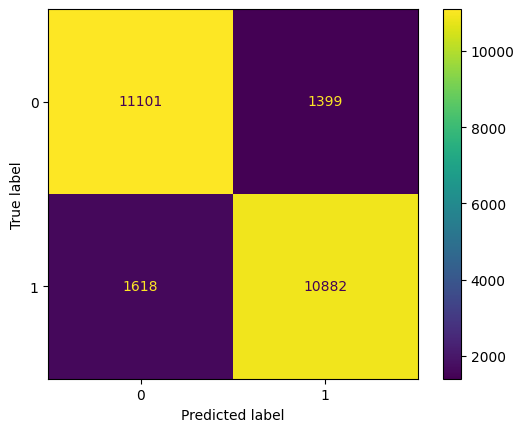

In [5]:
print(f'Test accuracy {accuracy_score(test_labels.reshape(1,-1)[0], preds)}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()  

782/782 [==============================] - 12s 12ms/step


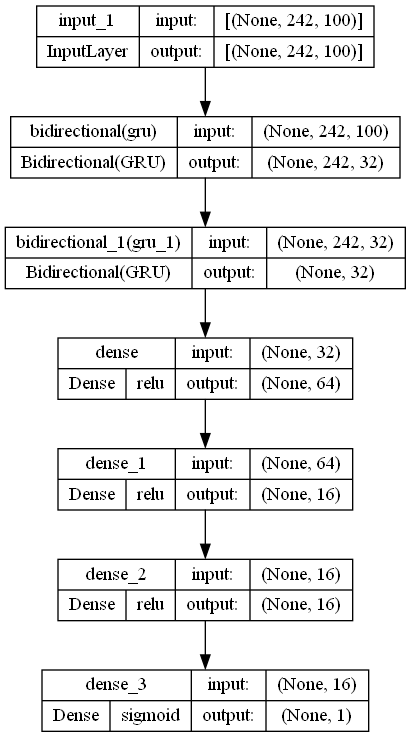

In [4]:
## 4
model = load_model(nns[3])
preds = model.predict(test_w2v)
preds = [0 if row < 0.50 else 1 for row in preds]
cm = confusion_matrix(test_labels.reshape(1,-1)[0], preds, labels=[0, 1])
keras.utils.plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)

Test accuracy 0.89076


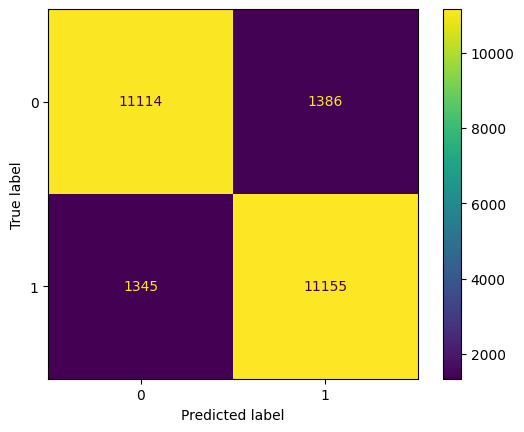

In [5]:
print(f'Test accuracy {accuracy_score(test_labels.reshape(1,-1)[0], preds)}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()  

# CNN Part

In [ ]:
max_wind = 242
W2V_SIZE = 4
W2V_WINDOW = 5
W2V_MIN_COUNT = 1
VEC_SIZE = 100

In [4]:
model = Sequential()
model.add(keras.Input(shape=(max_wind, VEC_SIZE,1)))
# conv2D = Conv2D(kernel_item, kernel_size=kernel_size, strides=(stride, stride), activation=activation, name="Conv_"+str(layer_counter), padding=padding)

model.add(Dropout(0.3))
model.add(layers.Conv2D(16, (5,5), padding='same', activation='relu'))

model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(layers.Conv2D(16, (5,5), padding='same', activation='relu'))

model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(layers.Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 242, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 242, 100, 16)      416       
                                                                 
 average_pooling2d (AverageP  (None, 121, 50, 16)      0         
 ooling2D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 121, 50, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 50, 16)       6416      
                                                                 
 average_pooling2d_1 (Averag  (None, 60, 25, 16)       0         
 ePooling2D)                                            

Epoch 1/10
352/352 [==============================] - 14s 25ms/step - loss: 0.5296 - accuracy: 0.7330 - val_loss: 0.4612 - val_accuracy: 0.7860
Epoch 2/10
352/352 [==============================] - 8s 24ms/step - loss: 0.4479 - accuracy: 0.7919 - val_loss: 0.4073 - val_accuracy: 0.8252
Epoch 3/10
352/352 [==============================] - 8s 24ms/step - loss: 0.4059 - accuracy: 0.8171 - val_loss: 0.3941 - val_accuracy: 0.8272
Epoch 4/10
352/352 [==============================] - 8s 23ms/step - loss: 0.3853 - accuracy: 0.8268 - val_loss: 0.3753 - val_accuracy: 0.8388
Epoch 5/10
352/352 [==============================] - 8s 23ms/step - loss: 0.3649 - accuracy: 0.8401 - val_loss: 0.3662 - val_accuracy: 0.8440
Epoch 6/10
352/352 [==============================] - 8s 24ms/step - loss: 0.3540 - accuracy: 0.8426 - val_loss: 0.3760 - val_accuracy: 0.8356
Epoch 7/10
352/352 [==============================] - 8s 24ms/step - loss: 0.3411 - accuracy: 0.8472 - val_loss: 0.3666 - val_accuracy: 0.842

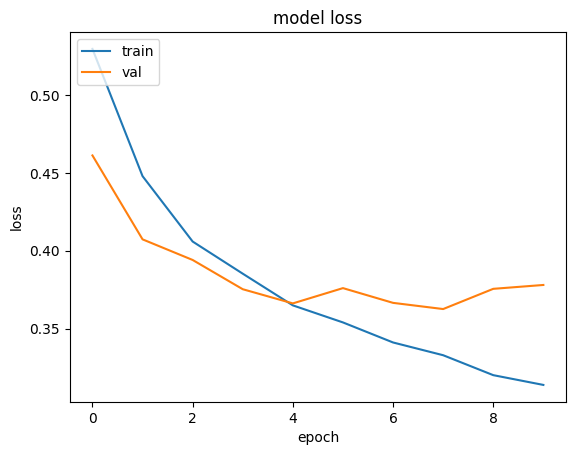

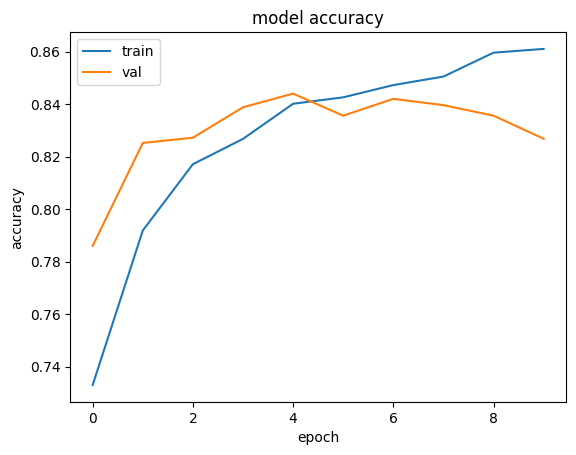

In [5]:
history = model.fit(train_w2v.reshape((25000,max_wind,VEC_SIZE,1)), train_labels, batch_size=64, epochs=10, validation_split=0.1)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

In [6]:
model.save_weights(f"models/cnn")
model.save(f'cnn.h5')

782/782 [==============================] - 7s 4ms/step


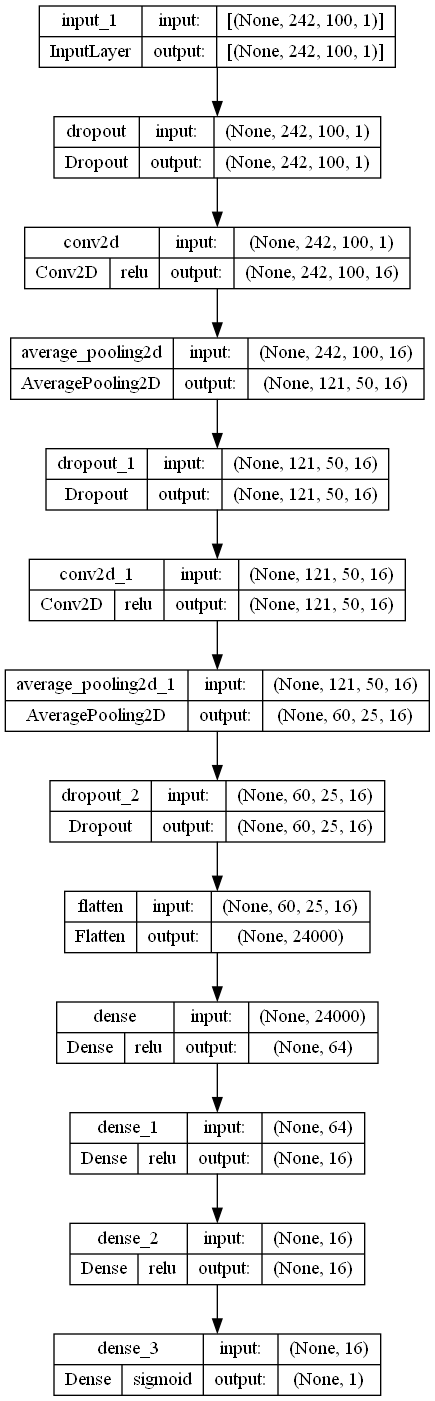

In [4]:
model = load_model('cnn.h5')
preds = model.predict(test_w2v)
preds = [0 if row < 0.50 else 1 for row in preds]
cm = confusion_matrix(test_labels.reshape(1,-1)[0], preds, labels=[0, 1])
keras.utils.plot_model(model, show_layer_activations=True, show_shapes=True, show_layer_names=True)

Test accuracy 0.84684


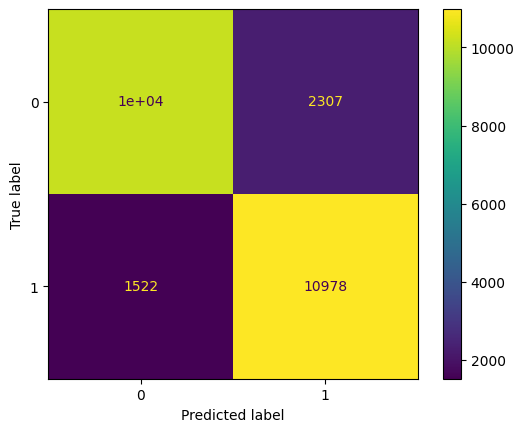

In [5]:
print(f'Test accuracy {accuracy_score(test_labels.reshape(1,-1)[0], preds)}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()  